# A Data Visualization Project About F1

This project uses Python libraries (Pandas, Matplotlib) and an API (fastf1) to showcase lap data for a chosen race. 

Specifically, I create a graph, which displays the fastest lap time for each driver in a certain race, sorts it by intervals (difference from the pole lap), and highlights the drivers, who ranked the same on this graph as in the final results in the race.
 
FastF1 Documentation: https://docs.fastf1.dev/

## Imports and setting up API

- I chose to analyse the 2024 British Grand Prix

- It is possible to change cache library, however I opted to use the default library in this project 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from timple.timedelta import strftimedelta

import fastf1
import fastf1.plotting
from fastf1.core import Laps

fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False, color_scheme=None)

In [2]:
fastf1.Cache.clear_cache()

In [59]:
session = fastf1.get_session(2024, "British Grand Prix", "R")
session.load()

core           INFO 	Loading data for British Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No ca

## Creating an array of the participating drivers

In [60]:
drivers = pd.unique(session.laps["Driver"])
drivers



array(['HAM', 'VER', 'NOR', 'PIA', 'SAI', 'HUL', 'STR', 'ALO', 'ALB',
       'TSU', 'SAR', 'MAG', 'RIC', 'LEC', 'BOT', 'OCO', 'PER', 'ZHO',
       'RUS', 'GAS'], dtype=object)

## Creating list of fastest laps

- I picked the fastest lap for each driver (built-in function in API), filter Na, sort values

- Picking pole lap

- Creating "LapTimeDelta" (intervals) attribue

In [61]:
list_fastest_laps = list()

for drv in drivers:
    drivers_fastest = session.laps.pick_drivers(drv).pick_fastest()
    # print(drivers_fastest["LapTime"])
    if drivers_fastest is not None and pd.notna(drivers_fastest["LapTime"]):
        list_fastest_laps.append(drivers_fastest)

fastest_laps = Laps(list_fastest_laps).sort_values("LapTime").reset_index(drop=True)

In [62]:
pole_lap = fastest_laps.pick_fastest()
fastest_laps["LapTimeDelta"] = fastest_laps["LapTime"] - pole_lap["LapTime"]

fastest_laps[["Driver", "LapTime", "LapTimeDelta"]]

,Driver,LapTime,LapTimeDelta
0,SAI,0 days 00:01:28.293000,0 days 00:00:00
1,PIA,0 days 00:01:28.748000,0 days 00:00:00.455000
2,VER,0 days 00:01:28.952000,0 days 00:00:00.659000
3,NOR,0 days 00:01:29.262000,0 days 00:00:00.969000
4,HAM,0 days 00:01:29.438000,0 days 00:00:01.145000
5,PER,0 days 00:01:29.707000,0 days 00:00:01.414000
6,ALO,0 days 00:01:29.710000,0 days 00:00:01.417000
7,ALB,0 days 00:01:29.718000,0 days 00:00:01.425000
8,LEC,0 days 00:01:29.748000,0 days 00:00:01.455000
9,HUL,0 days 00:01:29.836000,0 days 00:00:01.543000


## Creating color map

- Picks team color for each driver

- If the index of the driver in the fastest_laps array is equal to the index of the driver in the final results, I assign a vivid lime green color

In [63]:
team_colors = list()

for index, lap in fastest_laps.iterlaps():
    if (session.results.iloc[index]["Abbreviation"] == lap["Driver"]):
        color = "#13d91d"
    else:
        color = fastf1.plotting.get_team_color(lap["Team"], session=session)
    team_colors.append(color)

req            INFO 	Using cached data for driver_info


## Displaying graph

- Horizontal bar chart

- Highlighting bars, that have been assigned the specific green color

- Lables, title

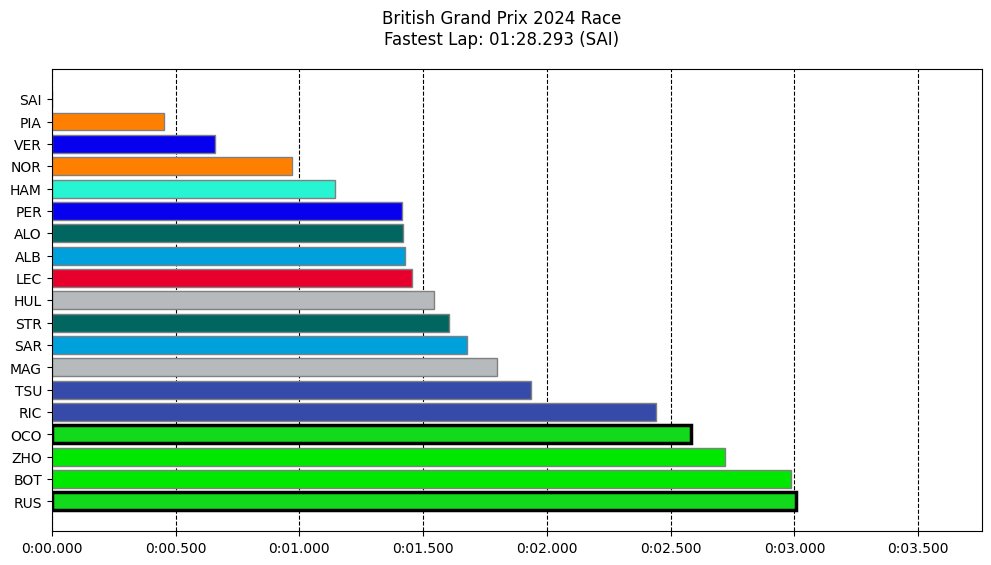

In [64]:
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.barh(fastest_laps.index, fastest_laps["LapTimeDelta"], color=team_colors, edgecolor="grey")
for bar, facecolor in zip(bars, team_colors):
    if facecolor == "#13d91d":
        bar.set_edgecolor("black")
        bar.set_linewidth(2.5)
        # bar.set_mouseover(True)
    # else:
    #     bar.set_edgecolor("grey")
    #     bar.set_linewidth(1)

ax.set_yticks(fastest_laps.index)
ax.set_yticklabels(fastest_laps["Driver"])


ax.invert_yaxis()

# max_delta = fastest_laps["LapTimeDelta"].max()
# ax.set_xlim(0, max_delta * 1.05)

ax.set_axisbelow(True)
ax.xaxis.grid(True, linestyle="--", color="black")

ax.margins(x=0.25)

lap_time_string = strftimedelta(pole_lap["LapTime"], "%m:%s.%ms")

plt.suptitle(f"{session.event["EventName"]} {session.event.year} Race\n"
                f"Fastest Lap: {lap_time_string} ({pole_lap["Driver"]})")

# plt.show()
plt.savefig(r"images\brit2024")

**Thanks to theOehrly for creating this API**